# Этапы CRISP-DM:
1. Анализ требований (Business Understanding) +

2. Исследование данных (Data Understanding) +

3. Подготовка данных (Data Preparation) 

4. Моделирование (Modeling)

5. Оценка (Evaluation)

6. Внедрение (Deployment)

# 1. Анализ требований 

Задача проекта - предсказать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой.

### Необходимые библиотеки

In [1]:
# Импортируем библиотеки для работы с матрицами и числовыми данными
import numpy as np  # для матричных вычислений и работы с массивами
# Импортируем библиотеку pandas для анализа и предобработки данных (работа с DataFrame)
import pandas as pd  # для загрузки, обработки и анализа табличных данных
# Импортируем matplotlib для создания графиков и визуализации данных
import matplotlib.pyplot as plt  # основной модуль для построения графиков
# Импортируем seaborn для создания стильных и информативных визуализаций
import seaborn as sns  # библиотека на основе matplotlib для улучшенной визуализации
# Импортируем модуль для линейных моделей из scikit-learn
from sklearn import linear_model  # для обучения и использования линейной регрессии
# Импортируем модуль метрик для оценки качества моделей
from sklearn import metrics  # для расчёта метрик, таких как MSE, R² и MAE
# Импортируем функцию для разбиения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split  # для разбиения данных на train/test
# Импортируем модуль для стандартизации/нормализации данных
from sklearn import preprocessing

### Знакомство с данными

1. age — возраст (целочисленное значение, например, 29 лет)

Тип данных: int64 (целое число)

2. sex — пол (например, "male" или "female")

Тип данных: object (строка/категориальный признак)

3. bmi — индекс массы тела (Body Mass Index), отношение веса к росту в квадрате

Тип данных: float64 (вещественное число)

4. children — количество детей, зависящих от застрахованного лица

Тип данных: int64 (целое число)

5. smoker — курит ли человек (например, "yes" или "no")

Тип данных: object (строка/категориальный признак)

6. region — регион проживания (например, "southwest", "northeast")

Тип данных: object (строка/категориальный признак)

7. charges — расходы на медицинское страхование (стоимость страховых выплат)

Тип данных: float64 (вещественное число)

In [2]:
insurance_data = pd.read_csv('Data/insurance.csv')

display(insurance_data.head())
print()
print(insurance_data.shape)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



(1338, 7)


У нас 1338 записей, 7 признаков.

In [3]:
print(insurance_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


Численных признаков - 4:
- age;
- bmi;
- children;
- charges (целевой);

Категориальных признаков - 3:
- sex;
- smoker;
- region.

In [4]:
print(insurance_data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Пропусков в данных нет.

# <center> ИТЕРАЦИЯ № 1

Пытаемся понять а возможно ли вообще сделать baseline на тех данных которые мы имеем?

# 2. Исследование данных

In [5]:
display(insurance_data.describe())
print()
display(insurance_data.describe(include='object'))

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [6]:
# Копируем датасет для последующей обработки
insurance_data_copy = insurance_data.copy()

# Выделяем отдельно категориальные и числовые признаки
num_features = list(insurance_data_copy.select_dtypes(include=['int64', 'float64']).columns)
cat_features = list(insurance_data_copy.select_dtypes(include=['object']).columns)

print(f'Числовые признаки: {num_features}')
print()
print(f'Категориальные признаки: {cat_features}')

Числовые признаки: ['age', 'bmi', 'children', 'charges']

Категориальные признаки: ['sex', 'smoker', 'region']


### Определение числовых зависимостей к целевому признаку charges

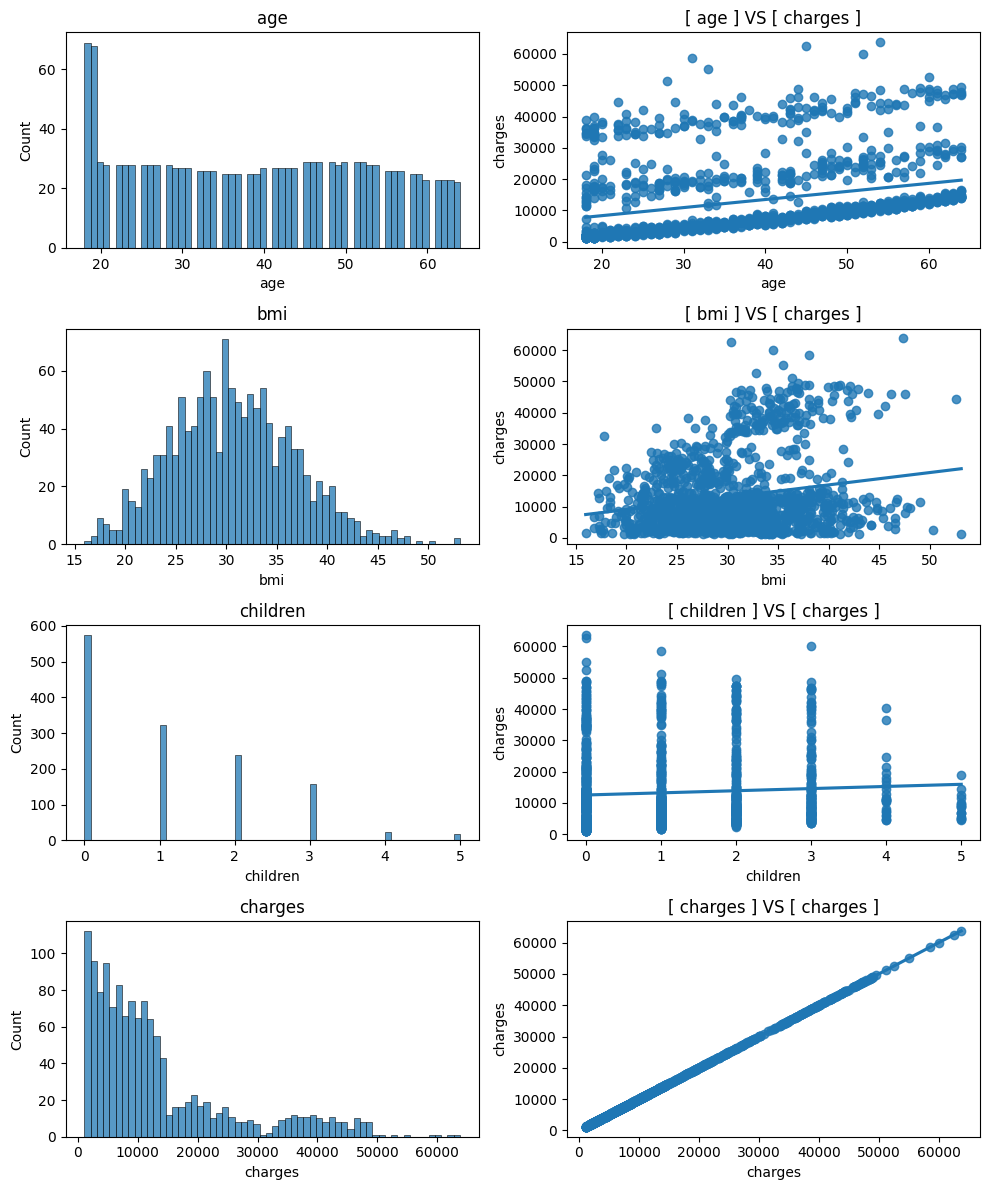

In [7]:
# Количество числовых признаков
num_of_rows = len(num_features)

# Создаем фигуру и набор осей
fig, axes = plt.subplots(num_of_rows, 2, figsize=(10, num_of_rows * 3))  # Динамическое изменение высоты

# Основные числовые признаки
for i, feature in enumerate(num_features):
    # Строим гистограмму распределения признака
    sns.histplot(data=insurance_data_copy, x=feature, bins=60, ax=axes[i][0]).set_title(f'{feature}')
    
    # Строим диаграмму рассеяния и линию регрессии
    sns.regplot(data=insurance_data_copy, x=feature, y='charges', ci=None, ax=axes[i][1]).set_title(f'[ {feature} ] VS [ charges ]')

# Плотная компоновка и отображение графиков
plt.tight_layout()
plt.show()

### Корреляция числовых признаков

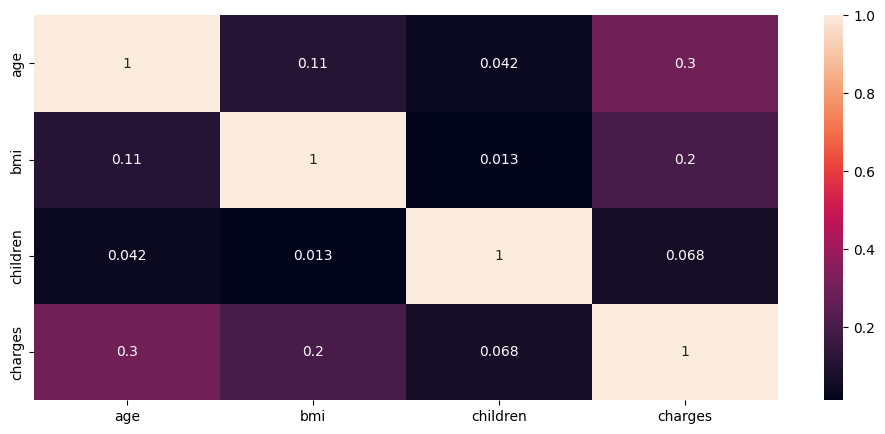

In [8]:
# Создаём фигуру для графика и устанавливаем размер 12x5 дюймов
fig = plt.figure(figsize=(12, 5))

# Строим тепловую карту (heatmap) корреляций между числовыми признаками в датасете
# insurance_data_copy.corr() вычисляет матрицу корреляций между числовыми столбцами
# Параметр annot=True добавляет значения корреляции на график в виде аннотаций
sns.heatmap(insurance_data_copy[num_features].corr(), annot=True);

В этом наборе данных нет сильных корреляций между признаками и целевой переменной (charges).

Наибольшая корреляция наблюдается между возрастом и расходами на страхование (0.3), но она всё ещё достаточно слабая для точного прогнозирования только на основе возраста или индекса массы тела.

# 3. Подготовка данных

### Кодирование категориальных признаков
Поскольку у нас в датасете есть категориальные признаки, нужно их закодировать.

In [9]:
# Преобразуем категориальные признаки в числовые с помощью метода get_dummies().
# Аргумент drop_first=True удаляет первый столбец каждой категории, чтобы избежать мультиколлинеарности.
insurance_data_copy['smoker'] = insurance_data_copy['smoker'].apply(lambda x: 0 if x == 'no' else 1)
insurance_data_copy['sex'] = insurance_data_copy['sex'].apply(lambda x: 0 if x == 'female' else 1)
data_dummies = pd.get_dummies(insurance_data_copy)

# Выводим первые 5 строк полученного DataFrame, чтобы проверить результат преобразования.
display(data_dummies.head())

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


### Разделение данных на матрицу наблюдений (X) и вектор правильных ответов (y).

In [10]:
X = data_dummies.drop(['charges'], axis=1) # матрица наблюдений (все признаки исключая целевой - charges)
y = data_dummies['charges'] # вектор правильных ответов (целевой признак charges)

### Разделяем датасет на тренировочную часть и тестовую часть

In [11]:
# Разделяем выборку на тренировочную и тестовую в соотношении 80/20
# Устанавливаем random_state для воспроизводимости результатов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (1070, 9) (1070,)
Test: (268, 9) (268,)


# 4. Моделирование данных

Построим модель линейной регрессии для предсказания суммы выплат.

In [12]:
# Функция которая отображает все виды метрик
def get_metrics(y_train, y_train_predict, y_test, y_test_predict):
    # Рассчитываем R2
    print(f"Train R^2: {round(metrics.r2_score(y_train, y_train_predict), 3)}")
    # Рассчитываем MAЕ
    print(f"Train MAE $: {round(metrics.mean_absolute_error(y_train, y_train_predict))}")
    # Рассчитываем MAPE
    print(f"Train MAPE %: {round(metrics.mean_absolute_percentage_error(y_train, y_train_predict) * 100)}")
    print('\n')
    # Рассчитываем R2
    print(f"Test R^2: {round(metrics.r2_score(y_test, y_test_predict), 3)}")
    # Рассчитываем MAЕ
    print(f"Test MAE $: {round(metrics.mean_absolute_error(y_test, y_test_predict))}")
    # Рассчитываем MAPE
    print(f"Test MAPE %: {round(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100)}")

### МНК

In [13]:
# Создаём объект класса LinearRegression
lr = linear_model.LinearRegression()

# Обучаем модель — ищем параметры по МНК (тренировочные данные)
lr.fit(X_train, y_train)

# Получаем предсказания
y_train_predict = lr.predict(X_train)
y_test_predict = lr.predict(X_test)

# Получаем метрики
get_metrics(y_train, y_train_predict, y_test, y_test_predict)
print()
# Вывод свободного члена (intercept) после стандартизации
print(f'w0: {round(lr.intercept_, 2)}') # свободный член w0

Train R^2: 0.742
Train MAE $: 4208
Train MAPE %: 42


Test R^2: 0.784
Test MAE $: 4181
Test MAPE %: 47

w0: -12390.8


### Метод градиентного спуска

Прежде чем приступать к расчетам нужно провести стандартизацию/нормализацию наших данных

In [14]:
# Инициализируем стандартизатор StandardScaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train) # Делаем fit только на тренировочной выборке иначе мы внесем смещение в данные!

# Производим стандартизацию
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [15]:
# Создаём объект класса LinearRegression
sgd_lr = linear_model.SGDRegressor(random_state=42)

# Обучаем модель — ищем параметры по МНК (тренировочные данные)
sgd_lr.fit(X_train_scaled, y_train)

# Получаем предсказания
y_train_predict = sgd_lr.predict(X_train_scaled)
y_test_predict = sgd_lr.predict(X_test_scaled)

# Получаем метрики
get_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.741
Train MAE $: 4118
Train MAPE %: 39


Test R^2: 0.782
Test MAE $: 4070
Test MAPE %: 43


Подсчет ошибок между тестовой и тренировочной выборками

Text(0, 0.5, 'Model')

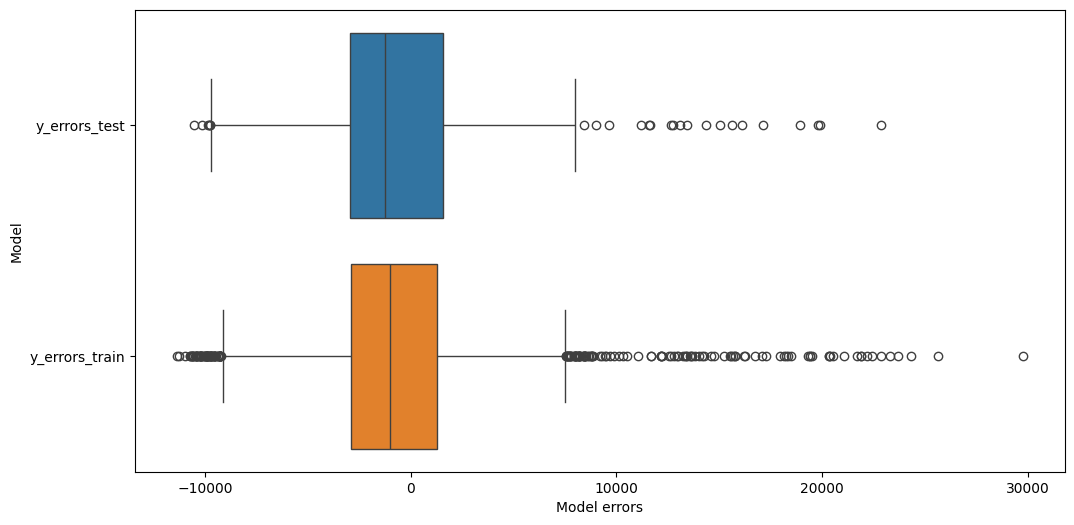

In [16]:
# Создаём фигуру и координатную плоскость с размером 12x6 дюймов. 
# Это пространство для визуализации графиков.
fig, ax = plt.subplots(figsize=(12, 6))

# Рассчитываем ошибки предсказания на тестовой выборке:
# Разница между реальными значениями (y_test) и предсказанными моделью (lr.predict(X_test)).
y_errors_lr_test = y_test - lr.predict(X_test)

# Рассчитываем ошибки предсказания на обучающей выборке:
# Разница между реальными значениями (y_train) и предсказанными значениями на обучающей выборке.
y_errors_lr_train = y_train - lr.predict(X_train)

# Создаём DataFrame из ошибок на обучающей и тестовой выборках.
errors_df = pd.DataFrame(
    {
        'y_errors_test': y_errors_lr_test,  # Ошибки на тестовой выборке
        'y_errors_train': y_errors_lr_train  # Ошибки на обучающей выборке
    }
)

# Строим boxplot (коробчатую диаграмму) для визуализации распределения ошибок.
# Параметр orient='h' задаёт горизонтальную ориентацию графика.
sns.boxplot(data=errors_df, orient='h', ax=ax)

# Устанавливаем подпись для оси X — "Model errors", чтобы показать, что здесь отображаются ошибки модели.
ax.set_xlabel('Model errors')

# Устанавливаем подпись для оси Y — "Model", чтобы указать, что сравниваем ошибки двух моделей (на обучающей и тестовой выборках).
ax.set_ylabel('Model')

# <center> ИТЕРАЦИЯ № 2

Нужна вторая итерация с улучшением наших показателей. Попробуем построить полиноминальную модель для расчета наших данных.

In [17]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)

# Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
# Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)

# Выводим результирующие размерности таблиц
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(1070, 54)
(268, 54)


In [18]:
# Создаём объект класса LinearRegression
lr_poly = linear_model.LinearRegression()
# Обучаем модель — ищем параметры по МНК (тренировочные данные)
lr_poly.fit(X_train_scaled_poly, y_train)

# Получаем предсказания
y_train_predict = lr_poly.predict(X_train_scaled_poly)
y_test_predict = lr_poly.predict(X_test_scaled_poly)

# Получаем метрики
get_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.842
Train MAE $: 2911
Train MAPE %: 30


Test R^2: 0.866
Test MAE $: 2754
Test MAPE %: 31


In [19]:
# Значения коэффициентов
print(f'Coef: {lr_poly.coef_}')

Coef: [-9.37866282e+16  1.30223120e+15  1.84674635e+16 -3.81590925e+16
  7.52833728e+14 -2.22336870e+14 -8.62402490e+13  3.69177315e+14
  2.15169079e+14  8.41600000e+03  8.48000000e+02  9.52000000e+02
 -1.69600000e+03  1.92000000e+02  9.37866282e+16  9.37866282e+16
  9.37866282e+16  9.37866282e+16  1.38403977e+15  6.41000000e+02
 -1.28600000e+03  2.57500000e+02 -2.68627097e+15 -2.68627097e+15
 -2.68627097e+15 -2.68627097e+15 -9.63662500e+03  1.56675000e+03
  5.48181250e+04 -1.84674635e+16 -1.84674635e+16 -1.84674635e+16
 -1.84674635e+16 -2.10393750e+03 -2.23600000e+03  3.81590925e+16
  3.81590925e+16  3.81590925e+16  3.81590925e+16  4.29480995e+14
 -1.18231472e+15 -1.18231472e+15 -1.18231472e+15 -1.18231472e+15
  2.17774288e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.04164626e+15  0.00000000e+00  0.00000000e+00  1.58622869e+15
  0.00000000e+00  1.74023693e+15]


Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация. Воспользуемся линейной регрессией с L1-регуляризацией (Lasso) на полиномиальных признаках.

In [22]:
# Создаём объект линейной модели с L1-регуляризацией (Lasso).
# Lasso помогает уменьшить значения коэффициентов и избавиться от малозначимых признаков,
# так как накладывает штраф на сумму модулей коэффициентов, что способствует "разреженности" модели (коэффициенты могут стать равными 0).
lasso_lr_poly = linear_model.Lasso(max_iter=2000)

# Обучаем Lasso-регрессию на полиномиальных признаках тренировочного набора данных.
# Данные предварительно масштабированы (X_train_scaled_poly).
lasso_lr_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказания на тренировочном наборе данных.
y_train_predict = lasso_lr_poly.predict(X_train_scaled_poly)

# Делаем предсказания на тестовом наборе данных.
y_test_predict = lasso_lr_poly.predict(X_test_scaled_poly)

# Вызываем функцию для вычисления метрик модели (например, MAE, MSE, R2) на обучающей и тестовой выборках.
get_metrics(y_train, y_train_predict, y_test, y_test_predict)

# Разделяем вывод для удобства.
print()

# Выводим коэффициенты модели, чтобы посмотреть, какие признаки модель оставила значимыми.
# В Lasso некоторые коэффициенты могут стать равными 0, что указывает на исключение этих признаков из модели.
print(lasso_lr_poly.coef_)

Train R^2: 0.842
Train MAE $: 2890
Train MAPE %: 29


Test R^2: 0.867
Test MAE $: 2719
Test MAPE %: 30

[ 3.24221653e+03 -4.92313816e+02  5.07612317e+03  4.58362056e+03
  1.97928569e+03  1.88025707e+02 -4.70775218e+02  5.83657101e+02
 -2.43543456e+02  8.29826751e+03  7.74581954e+02  8.44448593e+02
 -1.20775688e+03  1.34809915e+02 -1.04309726e+03 -0.00000000e+00
  1.16964229e+03  1.61765564e+03 -0.00000000e+00  5.05847740e+02
 -1.13425152e+03  2.65796922e+02 -1.22240479e+03  0.00000000e+00
  2.36213242e+02 -5.80031340e+02 -8.17963257e+03  1.29487768e+03
  5.47148553e+04  3.58531873e+03  2.40690210e+03 -9.63549427e+02
  0.00000000e+00 -1.67464337e+03 -2.05436459e+03  1.94204864e+03
  1.95394442e+03 -0.00000000e+00 -1.06364416e+03  8.00606774e+00
  5.93688978e+02 -0.00000000e+00 -2.30643423e+02  1.97933477e+03
  6.31615519e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.05849873e-01]


In [24]:
# Создаём объект линейной модели с L2-регуляризацией (Ridge).
# Ridge накладывает штраф на сумму квадратов коэффициентов, что предотвращает слишком большие значения коэффициентов,
# тем самым снижая риск переобучения.
ridge_lr_poly = linear_model.Ridge(max_iter=2000)

# Обучаем Ridge-регрессию на полиномиальных признаках тренировочного набора данных.
# Данные предварительно масштабированы (X_train_scaled_poly).
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказания на тренировочном наборе данных.
y_train_predict = ridge_lr_poly.predict(X_train_scaled_poly)

# Делаем предсказания на тестовом наборе данных.
y_test_predict = ridge_lr_poly.predict(X_test_scaled_poly)

# Вызываем функцию для вычисления метрик модели (например, MAE, MSE, R²) на обучающей и тестовой выборках.
get_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.839
Train MAE $: 2949
Train MAPE %: 30


Test R^2: 0.863
Test MAE $: 2861
Test MAPE %: 31


Можно пойти дальше и попробовать подобрать лучший показатель alpha для более оптимальных значений!

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.807e+09, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.807e+09, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

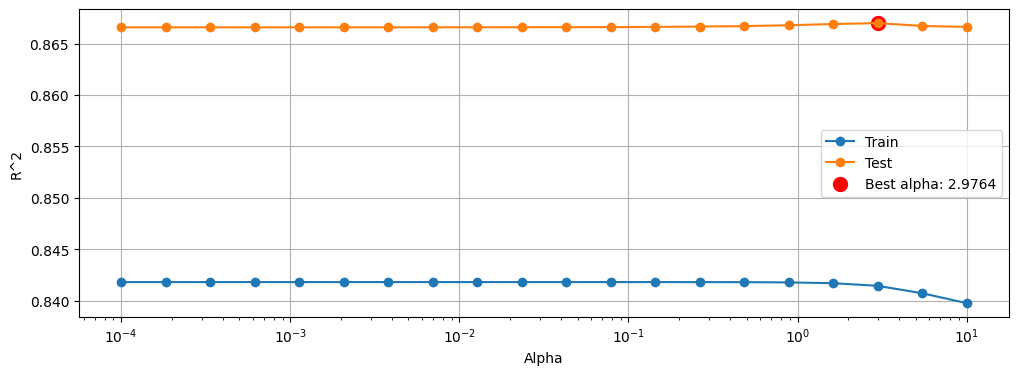

In [33]:
# Генерируем список значений alpha в логарифмическом масштабе от 0.0001 до 10
alpha_list = np.logspace(-4, 1, 20)

# Создаём пустые списки для хранения R^2 значений
train_scores = []
test_scores = []

# Перебираем значения alpha и обучаем модель на каждом из них
for alpha in alpha_list:
    # Создаём модель Lasso-регрессии с текущим alpha
    lasso_lr_poly = linear_model.Lasso(alpha=alpha, max_iter=5000)
    
    # Обучаем модель на тренировочных данных
    lasso_lr_poly.fit(X_train_scaled_poly, y_train)
    
    # Предсказываем значения для обучающей выборки
    y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
    
    # Предсказываем значения для тестовой выборки
    y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
    
    # Рассчитываем R^2 для обучающей и тестовой выборок и добавляем в списки
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))

# Определяем наилучшее значение alpha и соответствующий R^2 для тестовой выборки
best_alpha = alpha_list[np.argmax(test_scores)]
best_score = max(test_scores)

# Строим график зависимости R^2 от alpha
fig, ax = plt.subplots(figsize=(12, 4))

# График для обучающей выборки
ax.plot(alpha_list, train_scores, label='Train', marker='o')

# График для тестовой выборки
ax.plot(alpha_list, test_scores, label='Test', marker='o')

# Отмечаем наилучшее значение alpha красной точкой на графике
ax.scatter(best_alpha, best_score, color='red', s=100, label=f'Best alpha: {best_alpha:.4f}')

# Настройки осей
ax.set_xlabel('Alpha')  # Подпись оси X
ax.set_ylabel('R^2')  # Подпись оси Y
ax.set_xscale('log')  # Логарифмическая шкала для alpha

# Отображение легенды и сетки
ax.legend()
ax.grid(True)

# Показ графика
plt.show()

Оптимальное значение alpha найдено - 2.9764

In [34]:
# Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=2.9764)
# Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
# Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
# Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)

# Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.841
Test R^2: 0.867
